In [2]:
import keras
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import SGD

Using TensorFlow backend.


In [27]:
rainfall_data_monthly = pd.read_csv("data/All_India_Area_Weighted_Monthly_Rainfall.csv")

In [28]:
rainfall_data_monthly.head()

,Time,Value
0,1901-12-31,34.7
1,1902-01-31,38.6
2,1902-02-28,17.8
3,1902-03-31,38.9
4,1902-04-30,50.6


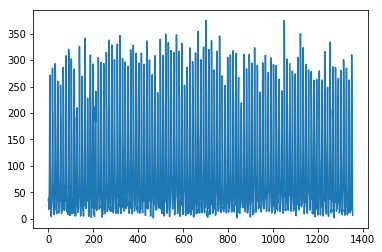

In [30]:
rainfall_data_monthly['Value'].plot()

In [31]:
rainfall_data_monthly['Time'] = pd.to_datetime(rainfall_data_monthly['Time'])

In [32]:
rainfall_data_monthly = rainfall_data_monthly.set_index('Time')

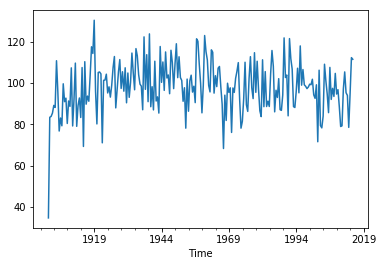

In [33]:
rainfall_data_monthly['Value'].resample('6M').mean().plot()

In [34]:
rainfall_data_monthly = rainfall_data_monthly.reset_index()

In [35]:
rainfall_data_monthly['Value_s_1']=rainfall_data_monthly['Value'].shift(1)
rainfall_data_monthly['Value_s_2']= rainfall_data_monthly['Value'].shift(2)
rainfall_data_monthly['Value_d_1']= rainfall_data_monthly['Value'].diff(1)

In [37]:
rainfall_data_monthly[['Value','Value_s_1','Value_s_2','Value_d_1']].loc[3]

Value        38.9
Value_s_1    17.8
Value_s_2    38.6
Value_d_1    21.1
Name: 3, dtype: float64

In [38]:
# lets split the data into train and test
# train ==> 4 splits , test ==> 1 split

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(rainfall_data_monthly.Time):
    y_train,y_test = rainfall_data_monthly['Value'][train_index],rainfall_data_monthly['Value'][test_index]
    x_train,x_test = rainfall_data_monthly[['Value_s_1','Value_s_2','Value_d_1']].loc[train_index],rainfall_data_monthly[['Value_s_1','Value_s_2','Value_d_1']].loc[test_index]

In [39]:
x_train = x_train[3:]
y_train = y_train[3:]

In [40]:
#x_train = x_train.values.reshape(-1,1)
#x_test = x_test.values.reshape(-1,1)

In [41]:
#y_train

In [42]:
# Scaling Y

scaler = MinMaxScaler(feature_range=(0,1))

x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)


In [43]:
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)
y_train = scaler.fit_transform(y_train)
y_test = scaler.fit_transform(y_test)


In [44]:
mlp_model = Sequential()
mlp_model.add(Dense(100, activation='sigmoid', input_dim=x_train.shape[1]))
mlp_model.add(Dense(100,activation='sigmoid'))
mlp_model.add(Dropout(0.2))
mlp_model.add(Dense(1,activation='sigmoid'))
opt = SGD(lr=0.001)
mlp_model.compile(loss='mean_squared_error', optimizer='adam')

In [45]:
mlp_model.fit(x_train,y_train,nb_epoch=50, batch_size=50, validation_split=0.2)

Train on 901 samples, validate on 226 samples
Epoch 1/50
901/901 [==============================] - 0s - loss: 0.1122 - val_loss: 0.0773
Epoch 2/50
901/901 [==============================] - 0s - loss: 0.0824 - val_loss: 0.0681
Epoch 3/50
901/901 [==============================] - 0s - loss: 0.0753 - val_loss: 0.0643
Epoch 4/50
901/901 [==============================] - 0s - loss: 0.0740 - val_loss: 0.0645
Epoch 5/50
901/901 [==============================] - 0s - loss: 0.0740 - val_loss: 0.0637
Epoch 6/50
901/901 [==============================] - 0s - loss: 0.0728 - val_loss: 0.0647
Epoch 7/50
901/901 [==============================] - 0s - loss: 0.0705 - val_loss: 0.0627
Epoch 8/50
901/901 [==============================] - 0s - loss: 0.0729 - val_loss: 0.0621
Epoch 9/50
901/901 [==============================] - 0s - loss: 0.0700 - val_loss: 0.0616
Epoch 10/50
901/901 [==============================] - 0s - loss: 0.0678 - val_loss: 0.0612
Epoch 11/50
901/901 [======================

In [46]:
preds = mlp_model.predict(x_test)

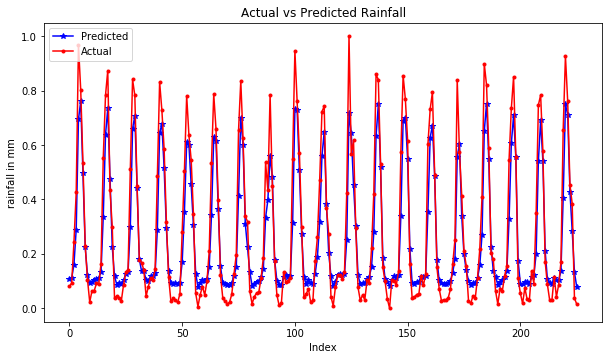

In [47]:
plt.figure(figsize=(10, 5.5))
plt.plot(preds,linestyle='-', marker='*',color='b')
plt.plot(y_test,linestyle='-', marker='.',color='r')
plt.legend(['Predicted','Actual'], loc=2)
plt.title('Actual vs Predicted Rainfall')
plt.ylabel('rainfall in mm')
plt.xlabel('Index')
plt.savefig('rain_fall_mlp', format='png', dpi=300)

In [48]:
from sklearn.metrics import r2_score

r2_score(y_test,preds)

0.88850317728633532

In [49]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, preds))

In [50]:
rmse

0.09412942423164658